In [6]:
import matplotlib
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure as Figure
import pylab
import sys
import os
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from skimage.draw import polygon
import json
import matplotlib.image as mpimg

#path to COCO images
coco_dir = '../data/mscoco'
dataType = 'train2014'
annFile='{}/annotations/instances_{}.json'.format(coco_dir,dataType)
cocoImgDir = '{}/images/{}/'.format(coco_dir, dataType)

In [10]:
# initialize COCO api for instance annotations
dataset_type = 'instances'
dataset = json.load(open(annFile, 'r'))

#not sure why this field not saved in my annotations?  But adding it here.
if 'type' not in dataset.keys():
    dataset['type'] = dataset_type
    with open(annFile, 'w') as outfile:
        json.dump(dataset, outfile)

coco=COCO(annFile)

loading annotations into memory...
Done (t=9.48s)
creating index...
index created!


In [11]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms='person');
person_id = catIds[0]
imgIds = coco.getImgIds(catIds=person_id);
imgId = imgIds[np.random.randint(0,len(imgIds))]
#imgId = 512657
img = coco.loadImgs(imgId)[0]

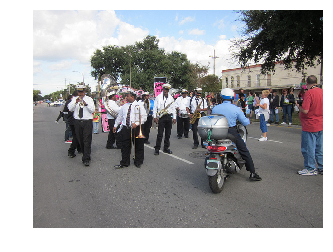

In [12]:
# load and display image
fig = plt.figure(frameon=False)
I=mpimg.imread('%s/COCO_%s_%012d.jpg' %(cocoImgDir, dataType, imgId))
plt.axis('off')
plt.imshow(I)

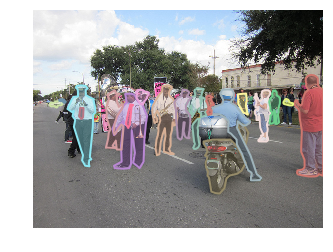

In [13]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [17]:
def get_mask_polygons(anns, catIds=[]):
    polygons = []
    for ann in anns:
        if ann['category_id'] in catIds:
            # polygon
            for seg in ann['segmentation']:
                poly = np.array(seg).reshape((len(seg)//2, 2))
                polygons.append(Polygon(poly, True,alpha=0.4))
    return polygons    

In [18]:
#get stuff to process image
colors = (0,0,0,1)
color_option = 'average' #other option 'black''
lines = open('../data/img_names.txt', 'r').readlines()
imgIds = [int(line) for line in lines]
imgIds = list(set(imgIds) & set(coco.getImgIds()))

In [ ]:
save_dir = '../data/blocked_images_%s/%s/' %(color_option, dataType)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for i, imgId in enumerate(imgIds):
    sys.stdout.write('\r%d/%d' %(i, len(imgIds)))
    img = coco.loadImgs(imgId)[0]
    save_file = '%s/%d_%s.png' %(save_dir, img['id'], color_option)
    if not os.path.isfile(save_file):
        
        fig = Figure()
        #canvas = FigureCanvas(fig)
        ax = fig.gca()

        
        I=mpimg.imread('%s/COCO_%s_%012d.jpg' %(cocoImgDir, dataType, imgId))
        # load and display instance annotations
        plt.cla()
        plt.imshow(I); #plt.axis('off')
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=False)
        anns = coco.loadAnns(annIds)
        polygons = get_mask_polygons(anns, [person_id])

        #code to make color average of scene
        if color_option == 'average':
            colors = []
            if I.ndim == 2:
                I = np.tile(I[..., np.newaxis], (1, 1, 3))
            for channel in range(3):
                colors.append(np.mean(I[:,:,channel])/255.)
        p = PatchCollection(polygons, facecolors=tuple(colors), edgecolors=tuple(colors), linewidths=10)

        ax = plt.gca()
        ax.add_collection(p)
        ax.set_axis_off()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
        ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())

        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

        plt.savefig(save_file, bbox_inches='tight', pad_inches=-0.05)

20/22966

/home/kaylee/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


18098/22966

In [ ]:
def get_segmentation_polygons(anns, catIds, W, H):
    polygons = []
    for ann in anns:
        if ann['category_id'] in catIds:
            # polygon            
            for seg in ann['segmentation']:
                poly = []
                num_points = len(seg) // 2
                for i in xrange(num_points):
                    x, y = seg[2 * i], seg[2 * i + 1]
                    assert(x<=W)
                    assert(y<=H)
                    poly.append((min(x,W-1), min(y,H-1)))
                poly = np.array(poly)
                polygons.append(poly)                
    return polygons

In [ ]:
def save_person_segmentations(coco, cocoImgDir, coco_masks, img_path):    
    catIds = coco.getCatIds(catNms='person');
    person_id = catIds[0]

    lines = open(img_path, 'r').readlines()
    imgIds = [int(line) for line in lines]
    imgIds = list(set(imgIds) & set(coco.getImgIds()))

    for i, imgId in enumerate(imgIds):
        sys.stdout.write('\r%d/%d' %(i, len(imgIds)))
        img = coco.loadImgs(imgId)[0]
        save_file = '%s/COCO_%s_%012d.npy' %(coco_masks, dataType, img['id'])
        if not os.path.isfile(save_file):
            #fig = plt.figure(frameon=False)
            #ax = fig.gca()
            I=mpimg.imread('%s/COCO_%s_%012d.jpg' %(cocoImgDir, dataType, imgId))
            #plt.cla()
            H, W = I.shape[0:2]
            annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=False)
            anns = coco.loadAnns(annIds)
            polygons = get_segmentation_polygons(anns, [person_id], W, H)      
            seg_map = np.zeros(I.shape[:2])
            for poly in polygons:
                rr, cc = polygon(poly[:, 0], poly[:, 1])
                seg_map[cc, rr] = 1
            #plt.imshow(seg_map)
            #plt.show()
            np.save(save_file, seg_map)
    print ('done')

In [ ]:
dataType = 'val2014'
annFile='{}/annotations/instances_{}.json'.format(coco_dir,dataType)
cocoImgDir = '{}/images/{}/'.format(coco_dir, dataType)
coco_masks = '{}/masks/{}/'.format(coco_dir, dataType)
coco=COCO(annFile)

if not os.path.isdir(coco_masks):
    os.makedirs(coco_masks)
    
save_person_segmentations(coco, cocoImgDir, coco_masks, '../data/balanced_split/val_woman.txt')
save_person_segmentations(coco, cocoImgDir, coco_masks, '../data/balanced_split/val_man.txt')
save_person_segmentations(coco, cocoImgDir, coco_masks, '../data/balanced_split/test_woman.txt')
save_person_segmentations(coco, cocoImgDir, coco_masks, '../data/balanced_split/test_man.txt')